# BIOINFORMATICS AND NETWORK MEDICINE

# Putative disease gene identification and drug repurposing for Ciliopathies 


### Mohamamdmehdi Razavi - Razavi.2023856@studenti.uniroma1.it
### Ousainou Panneh - panneh.1847923@studenti.uniroma1.it
### Jinjia Qian - qian.2047931@studenti.uniroma1.it


# Part 1:PPI and GDA data gathering and interactome reconstruction


## part 1.1:Download PPIs from BioGRID latest release to build the human interactome


In [6]:
import pandas as pd
import networkx as nx
from urllib.request import urlretrieve
import zipfile
import os

# Load the data into a DataFrame
path = r'C:\Users\mehdi\Desktop\Untitled Folder\Data\BIOGRID_ALL_tab3.txt'
biogrid_df = pd.read_csv(path , delimiter='\t')

# Filter for Homo sapiens interactions
biogrid_df = biogrid_df[(biogrid_df['Organism ID Interactor A'] == 9606) & 
                        (biogrid_df['Organism ID Interactor B'] == 9606)]

# Keep only physical interactions
biogrid_df = biogrid_df[biogrid_df['Experimental System Type'] == 'physical']

# Remove self-loops and duplicates
biogrid_df = biogrid_df[biogrid_df['BioGRID ID Interactor A'] != biogrid_df['BioGRID ID Interactor B']]
biogrid_df = biogrid_df.drop_duplicates(subset=['BioGRID ID Interactor A', 'BioGRID ID Interactor B'])

# Build the network
G = nx.from_pandas_edgelist(biogrid_df, 'Official Symbol Interactor A', 'Official Symbol Interactor B')

# Isolate the largest connected component (LCC)
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

# Save the largest connected component for further analysis
nx.write_edgelist(G, "largest_connected_component.edgelist", delimiter='\t')
print(G_lcc.size())


C:\Users\mehdi\AppData\Local\Temp\ipykernel_14704\226573121.py:9: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  biogrid_df = pd.read_csv(path , delimiter='\t')


822762


## part 1.2: Gather gene-disease associations (GDAs) data from DisGeNET 


In [7]:
import pandas as pd

# Path to the GDA Excel file
gda_file_path = r"C:\Users\mehdi\Desktop\Untitled Folder\Data\C4277690_disease_gda_summary_CURATED.xlsx"

# Read the GDA data
gda_df = pd.read_excel(gda_file_path)
gda_df.to_csv("cleaned_gda_data.csv", index=False)

## part 1.3 : Compute and characterize the disease LCC and its basic network measures



Number of associated genes:
110
The number of genes present in the interactome:
104
LCC size of the disease interactome(total number of edges):
120


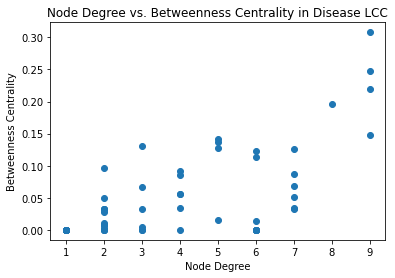

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the interactome data (LCC from point 1.1)
G = nx.read_edgelist("largest_connected_component.edgelist")

# Load the GDA data (assuming you have a column for gene names)
gda_df = pd.read_csv("cleaned_gda_data.csv")
print("Number of associated genes:")
print(len(gda_df.Gene))
disease_genes = set(gda_df['Gene'])

# Create subgraph with disease genes
disease_interactome = G.subgraph(disease_genes)

print("The number of genes present in the interactome:")
print(len(disease_interactome.nodes()))

# Identify the disease LCC
largest_cc = max(nx.connected_components(disease_interactome), key=len)
disease_lcc = disease_interactome.subgraph(largest_cc).copy()
print("LCC size of the disease interactome(total number of edges):")
print(disease_lcc.size())
# Compute network metrics
degree = dict(disease_lcc.degree())
betweenness = nx.betweenness_centrality(disease_lcc)
eigenvector = nx.eigenvector_centrality(disease_lcc, max_iter=500)
closeness = nx.closeness_centrality(disease_lcc)
ratio_betw_deg = {node: betweenness[node]/degree[node] for node in disease_lcc.nodes}

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    'Gene Name': list(degree.keys()),
    'Degree': list(degree.values()),
    'Betweenness': list(betweenness.values()),
    'Eigenvector Centrality': list(eigenvector.values()),
    'Closeness Centrality': list(closeness.values()),
    'Ratio Betweenness/Degree': list(ratio_betw_deg.values())
})

# Sort by Degree and select top 50 genes
top_50_genes = metrics_df.sort_values('Degree', ascending=False).head(50)

# Table 2: Main network metrics of disease LCC genes
top_50_genes.to_csv('top_50_disease_genes_metrics.csv', index=False)

# Scatterplot of Node Degree vs. Betweenness
plt.scatter(metrics_df['Degree'], metrics_df['Betweenness'])
plt.xlabel('Node Degree')
plt.ylabel('Betweenness Centrality')
plt.title('Node Degree vs. Betweenness Centrality in Disease LCC')
plt.savefig('degree_betweenness_scatterplot.png')
plt.show()


In [9]:
gda_df.Gene.to_csv("seed.txt", sep=",", index = False, header = False)
# Create the total ppi .txt and .tsv
totalPpi = biogrid_df[["Official Symbol Interactor A" , "Official Symbol Interactor B"]]
totalPpi = totalPpi.rename(columns={'Official Symbol Interactor A': 'Gene1', 'Official Symbol Interactor B': 'Gene2'})
totalPpi.to_csv("totalPpi.tsv", sep="\t", index=False)
totalPpi.to_csv("totalppi.txt", sep=",", index=False,header=False)


# part 2:Comparative analysis of the disease genes identification algorithms


## 2.1: Use the following algorithms to infer and validate (point 2.2) putative disease genes:

In [100]:

# Assuming 'seed_genes' is your list of known disease genes and 'network' is your interactome network
# You may need to adjust these parameters according to your data format and the DIAMOnD documentation

!python  DIAMOnD.py  totalppi.txt  seed.txt  100 Disease_DIAMOND.txt


DIAMOnD(): ignoring 6 of 110 seed genes that are not in the network

 results have been saved to 'Disease_DIAMOND.txt' 



In [101]:
test = pd.read_csv("Disease_DIAMOND.txt", sep = '\t')
print(test.sort_values(by=['p_hyper']))

    #rank DIAMOnD_node       p_hyper
50     51        CEP72  8.186954e-29
48     49         POC5  9.318644e-29
49     50        KRT19  2.696095e-28
59     60      FAM184A  5.820018e-28
47     48        HAUS1  7.641349e-28
..    ...          ...           ...
5       6         PCM1  8.233135e-09
1       2       UNC45A  1.174886e-08
2       3        HAUS8  1.864072e-08
3       4       DNAJC7  2.535113e-08
4       5      GPATCH1  4.886438e-08

[100 rows x 3 columns]


In [102]:
!python  DIABLE.py  totalppi.txt  seed.txt  100 Disease_DIABLE.txt


DIAMOnD(): ignoring 6 of 110 seed genes that are not in the network

 results have been saved to 'Disease_DIABLE.txt' 



In [103]:
test = pd.read_csv("Disease_DIABLE.txt", sep = '\t')
print(test.sort_values(by=['p_hyper']))

    #rank DIAMOnD_node       p_hyper
48     49         POC5  1.948972e-28
49     50        KRT19  7.105536e-28
47     48        HAUS1  1.794255e-27
41     42        CENPJ  1.020523e-26
46     47        HAUS5  1.490605e-26
44     45         PCNT  5.720664e-26
40     41         TCHP  7.144361e-26
45     46        KRT18  8.838928e-26
33     34       CCDC66  1.000844e-25
43     44     MPHOSPH9  1.525532e-25
42     43         NINL  2.250423e-25
35     36         MIB1  3.643835e-25
36     37       WRAP73  7.371813e-25
34     35       CCDC77  1.187710e-24
39     40       CEP152  1.640614e-24
38     39        HAUS2  1.815276e-24
32     33         MED4  1.026015e-23
31     32        CEP63  1.714299e-23
37     38       CEP170  1.890532e-23
30     31       SPICE1  2.694632e-22
29     30        NDC80  2.729965e-21
27     28       CEP131  8.489970e-21
28     29        PIBF1  1.131382e-20
26     27      FGFR1OP  5.764510e-20
25     26       CCDC14  3.027988e-19
23     24        HAUS7  3.531333e-19
2

## part 2.2: Computational validation



In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming 'disease_genes' is your list of known disease genes (GDAs)
disease_genes = np.array(gda_df.Gene)  # Convert to NumPy array for easier manipulation
n = len(disease_genes)

# Define function to run your chosen algorithm (replace with actual function call)
def run_algorithm(training_set, i):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(training_set)
    df.to_csv("seed.txt", sep=",", index=False,header=False)
    output = "Disease_DIAMOND_fold{}.txt".format(i)
    !python  DIAMOnD.py  totalppi.txt  seed.txt  100 output
    pass

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0
for train_index, test_index in kf.split(disease_genes):
    ST = disease_genes[train_index]  # Training set
    SP = disease_genes[test_index]  # Probe set (test set)

    run_algorithm(ST, i)
    predicted_genes = pd.read_csv("output" , delimiter='\t').DIAMOnD_node
    i += 1
    # Evaluate performance for top 50 and other specified positions
    for top_k in [50, int((1/10) * n), int((1/4) * n), int((1/2) * n), n]:
        top_predicted = set(predicted_genes[:top_k])
        true_positives = top_predicted.intersection(SP)

        precision = len(true_positives) / len(top_predicted)
        recall = len(true_positives) / len(SP)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

# Calculate average and standard deviation for each metric
avg_precision = np.mean(precisions)
sd_precision = np.std(precisions)
avg_recall = np.mean(recalls)
sd_recall = np.std(recalls)
avg_f1 = np.mean(f1_scores)
sd_f1 = np.std(f1_scores)

print("all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(precisions)

print("all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(recalls)

print("all f1_scores for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(f1_scores)

print(f"average Precision: {avg_precision:.2f} ± {sd_precision:.2f}")
print(f"average Recall: {avg_recall:.2f} ± {sd_recall:.2f}")
print(f"average F1 Score: {avg_f1:.2f} ± {sd_f1:.2f}")


DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output' 

DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output' 

DIAMOnD(): ignoring 3 of 88 seed genes that are not in the network

 results have been saved to 'output' 

DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output' 

DIAMOnD(): ignoring 6 of 88 seed genes that are not in the network

 results have been saved to 'output' 

all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.02, 0.09090909090909091, 0.037037037037037035, 0.01818181818181818, 0.01, 0.1, 0.2727272727272727, 0.18518518518518517, 0.09090909090909091, 0.05, 0.08, 0.2727272727272727, 0.14814814814814814, 0.07272727272727272, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.2727272727272727, 0.1111111111111111, 0.07272727272727272, 0.04]
all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.045454545

### Diable


In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming 'disease_genes' is your list of known disease genes (GDAs)
disease_genes = np.array(gda_df.Gene)  # Convert to NumPy array for easier manipulation
n = len(disease_genes)

# Define function to run your chosen algorithm (replace with actual function call)
def run_algorithm(training_set, i):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(training_set)
    df.to_csv("seed.txt", sep=",", index=False,header=False)
    !python  DIABLE.py  totalppi.txt  seed.txt  100 output2
    pass

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0
for train_index, test_index in kf.split(disease_genes):
    ST = disease_genes[train_index]  # Training set
    SP = disease_genes[test_index]  # Probe set (test set)

    run_algorithm(ST, i)
    predicted_genes = pd.read_csv("output" , delimiter='\t').DIAMOnD_node
    i += 1
    # Evaluate performance for top 50 and other specified positions
    for top_k in [50, int((1/10) * n), int((1/4) * n), int((1/2) * n), n]:
        top_predicted = set(predicted_genes[:top_k])
        true_positives = top_predicted.intersection(SP)

        precision = len(true_positives) / len(top_predicted)
        recall = len(true_positives) / len(SP)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

# Calculate average and standard deviation for each metric
avg_precision = np.mean(precisions)
sd_precision = np.std(precisions)
avg_recall = np.mean(recalls)
sd_recall = np.std(recalls)
avg_f1 = np.mean(f1_scores)
sd_f1 = np.std(f1_scores)

print("all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(precisions)

print("all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(recalls)

print("all f1_scores for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(f1_scores)

print(f"average Precision: {avg_precision:.2f} ± {sd_precision:.2f}")
print(f"average Recall: {avg_recall:.2f} ± {sd_recall:.2f}")
print(f"average F1 Score: {avg_f1:.2f} ± {sd_f1:.2f}")


DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output2' 

DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output2' 

DIAMOnD(): ignoring 3 of 88 seed genes that are not in the network

 results have been saved to 'output2' 

DIAMOnD(): ignoring 5 of 88 seed genes that are not in the network

 results have been saved to 'output2' 

DIAMOnD(): ignoring 6 of 88 seed genes that are not in the network

 results have been saved to 'output2' 

all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.2727272727272727, 0.1111111111111111, 0.07272727272727272, 0.04]
all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13636363636363635, 0.13636363636363635, 0.1363636363

# part3:Putative disease gene identification



## Part 3.1:

In [26]:
# Assuming you have a function for your best-performing algorithm
# For example, let's say it's the DIAMOnD algorithm. Replace this with your actual function.
def best_performing_algorithm(seed_genes):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(seed_genes)
    df.to_csv("seed.txt", sep=",", index=False,header=False)
    !python  DIAMOnD.py  totalppi.txt  seed.txt  100 output_best
    pass

# Assuming 'all_known_gdas' is your list of all known GDAs
seed_genes = np.array(gda_df.Gene)

# Run the algorithm
predicted_putative_genes = best_performing_algorithm(seed_genes)
df = pd.read_csv("output_best", sep = '\t')
top_gene = df.DIAMOnD_node
top_gene.to_csv("top_gene.txt", sep=",", index=False,header=False)
print("Top 100 putative disease genes have been identified and saved.")


DIAMOnD(): ignoring 6 of 110 seed genes that are not in the network

 results have been saved to 'output_best' 

Top 100 putative disease genes have been identified and saved.




## part 3.2: Enrichment analysis


In [27]:
# Path to the GDA Excel file
gda_file_path = r"C:\Users\mehdi\Desktop\Untitled Folder\Data\C4277690_disease_gda_summary_CURATED.xlsx"

# Read the GDA data
gda_df = pd.read_excel(gda_file_path)
gda_df.Gene.to_csv("all_gene.txt", sep=",", index=False,header=False)


# Part 4: Drug repurposing


## Part 4.1: Drug identification


## Part 4.2: Clinical Trials validation

# Part 5 : Optional Task



In [76]:
import markov_clustering as mc
import networkx as nx
import random
from datetime import datetime

# Assuming 'lcc_edges_file' contains the edges of the LCC
G = nx.read_edgelist("largest_connected_component.edgelist")

### Find all communities in the human interactome (LCC) with MCL

In [80]:

def run_mcl(graph, inflation):
    start_time = datetime.now()
    # Alternative MCL implementation using networkx
    matrix= matrix = nx.to_numpy_array(graph)
    result = mc.run_mcl(matrix, inflation = inflation)           # run MCL with default parameters
    clusters = mc.get_clusters(result)
    index_to_label = {index: label for index, label in enumerate(graph.nodes())}
    # Use the mapping to convert cluster indices to original node labels
    communities = {i: [index_to_label[node] for node in cluster] for i, cluster in enumerate(clusters)}
    end_time = datetime.now()
    print ( 'Elapsed time:' + str(end_time - start_time))
    return communities

# Run MCL with different inflation values
inflation_values = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
# inflation_values = [1.8]
mcl_clusters = {inflation: run_mcl(G, inflation) for inflation in inflation_values}


Elapsed time:1:10:55.956601
Elapsed time:0:53:33.073668
Elapsed time:0:55:05.922628
Elapsed time:0:56:35.993539
Elapsed time:0:54:19.067377
Elapsed time:0:55:13.553476


In [83]:
import networkx as nx
import community as community_louvain

def detect_communities_louvain(interactome_graph):
    # Apply the Louvain algorithm
    partition = community_louvain.best_partition(interactome_graph, resolution=1)
    communities = {}
    for node, community_id in partition.items():
        communities.setdefault(community_id, []).append(node)
    return communities

LV_community = detect_communities_louvain(G)

In [139]:
from scipy.stats import hypergeom
def identify_disease_modules(communities, disease_genes, total_genes):
    putative_disease_modules = []
    for community_id, genes in communities.items():
        if 10 <= len(genes) <= 1000:
            num_disease_genes_in_community = len(set(genes) & set(disease_genes))
            # Ensure all arguments are integers
            total_genes_int = int(total_genes)
            num_disease_genes_int = int(len(disease_genes))
            num_genes_in_community = int(len(genes))
            num_disease_genes_in_community_int = int(num_disease_genes_in_community)

            p_value = hypergeom.sf(num_disease_genes_in_community_int - 1, total_genes_int, num_disease_genes_int, num_genes_in_community)
#             print(p_value)
#             print(num_disease_genes_in_community)
            if p_value < 0.05:  # Assuming a significance level of 0.05
                putative_disease_modules.append((community_id, genes, num_disease_genes_in_community_int))
    return putative_disease_modules


In [140]:
identify_disease_modules(LV_community, gda_df.Gene,len(list(G.nodes())))


[]